In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


In [18]:
# Chemins
BASE_DIR = "../dataset/images"

# Paramètres images
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 1   # Grayscale

# Paramètres training
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42


Générateurs d’images (TRAIN / VAL)

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)


Chargement des données

In [20]:
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=SEED
)

Found 1849 images belonging to 10 classes.
Found 457 images belonging to 10 classes.


Vérification des classes

In [21]:
print("Classes détectées :")
for cls, idx in train_generator.class_indices.items():
    print(f"{idx} → {cls}")

print("\nNombre de classes :", train_generator.num_classes)


Classes détectées :
0 → crease
1 → crescent_gap
2 → inclusion
3 → oil_spot
4 → punching_hole
5 → rolled_pit
6 → silk_spot
7 → waist_folding
8 → water_spot
9 → welding_line

Nombre de classes : 10


Visualisation rapide

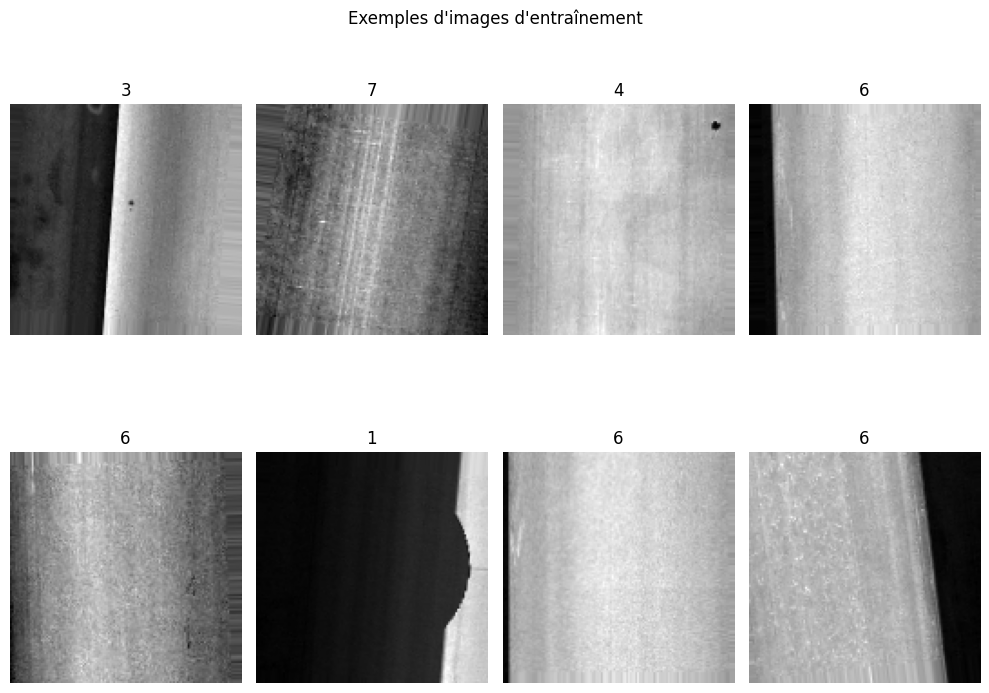

In [22]:
images, labels = next(train_generator)

plt.figure(figsize=(10,8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Exemples d'images d'entraînement")
plt.show()




**CONCEPTION DU CNN**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam


In [24]:
# Paramètres du modèle
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)  # Grayscale
NUM_CLASSES = 10
LEARNING_RATE = 1e-3

In [25]:
#Construction du modèle CNN

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
 
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])


Compilation du modèle

In [26]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [27]:
# resumé du modele

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,354 (12.61 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**ENTRAÎNEMENT DU CNN**

In [28]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

Définition des callbacks

In [29]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="../models/cnn_defect_classifier.keras",
        monitor="val_loss",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

Entraînement du modèle

In [30]:
EPOCHS = 30
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30


2026-02-03 14:55:32.008547: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 14:55:32.650549: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 520 bytes spill stores, 520 bytes spill loads



50/58 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.2248 - loss: 2.2095

2026-02-03 14:55:44.783211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_882', 8 bytes spill stores, 8 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - accuracy: 0.2558 - loss: 2.1262 - val_accuracy: 0.2845 - val_loss: 2.0029 - learning_rate: 0.0010
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.2958 - loss: 1.9964 - val_accuracy: 0.2998 - val_loss: 1.7920 - learning_rate: 0.0010
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.3083 - loss: 1.9365 - val_accuracy: 0.2998 - val_loss: 1.8716 - learning_rate: 0.0010
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.3261 - loss: 1.8929 - val_accuracy: 0.3414 - val_loss: 1.7701 - learning_rate: 0.0010
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.3245 - loss: 1.8783 - val_accuracy: 0.3085 - val_loss: 1.7685 - learning_rate: 0.0010
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.3332 - loss: 1.8654 - val_accuracy: 0.3195 - val_loss: 2.0278 - learning_rate: 0.0010
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.3407 - loss: 1.8300 - val_

Visualisation des performances

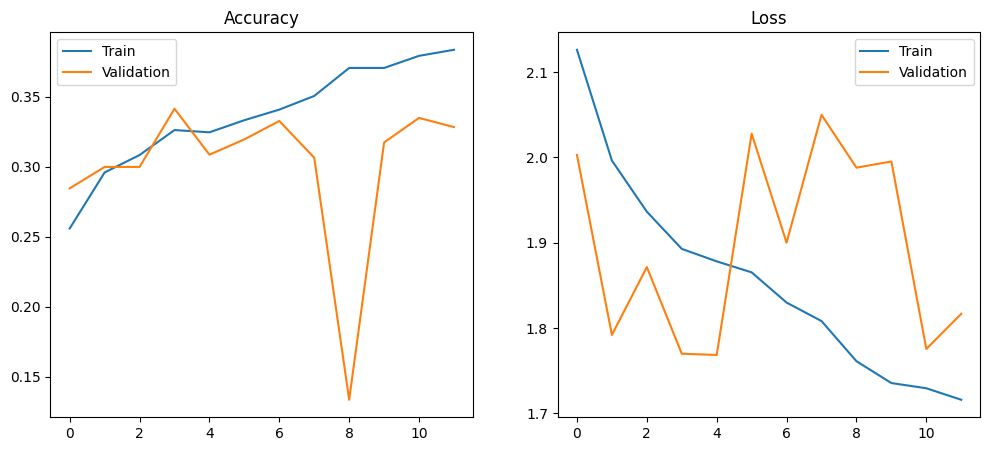

In [31]:
import matplotlib.pyplot as plt

def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_training(history)

Modèle sauvegardé

In [32]:
# Sauvegarde explicite du modèle final
# model.save("../models/cnn_defect_classifier.keras")
print("✅ Modèle sauvegardé dans models/cnn_defect_classifier.keras")


✅ Modèle sauvegardé dans models/cnn_defect_classifier.keras
